# Identifying and visualizing wildfire causes

## import important packages and loading data from SQL database

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import psycopg2
from sql_functions import get_engine
from sql_functions import get_sql_config
from sql_functions import get_dataframe
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [2]:
#download fires_data from our SQL base with columns unique_id, state_name, combined_discovery_date and fire_size
fires_data = get_dataframe('SELECT unique_id, state_name, combined_discovery_date, fire_size, cause_descr FROM capstone_wildfire.fires_data_v1_rdy_to_clean_rows')

In [3]:
fires_data

,unique_id,state_name,combined_discovery_date,fire_size,cause_descr
0,1758431,New York,2009-04-24 19:25:00,1.20,Arson
1,1758432,New York,2009-04-25 15:56:00,0.75,Miscellaneous
2,1758433,New York,2009-09-26 18:03:00,2.75,Children
3,1758434,New York,2009-11-04 15:19:00,0.50,Arson
4,1758435,New York,2009-04-12 13:18:00,1.20,Lightning
...,...,...,...,...,...
1674433,1758426,New York,2009-04-10 12:15:00,0.75,Miscellaneous
1674434,1758427,New York,2009-04-16 15:22:00,1.15,Miscellaneous
1674435,1758428,New York,2009-04-25 10:45:00,0.75,Lightning
1674436,1758429,New York,2009-04-28 12:05:00,0.95,Miscellaneous


## cleaning

### creating month & season column

In [4]:
#creating a 'month' column in fires_data just to contain the month as integer to better group by month
fires_data['month'] = fires_data['combined_discovery_date'].dt.month

In [5]:
#creating a 'quarter' column to just contain the quarter as int to better group by calendarial quarter
# Define a function to map months to quarters
def get_quarter(month):
    if 1 <= month <= 3:
        return 1
    elif 4 <= month <= 6:
        return 2
    elif 7 <= month <= 9:
        return 3
    else:
        return 4

# Apply the function to create the 'quarter' column
fires_data['quarter'] = fires_data['month'].apply(get_quarter)

# Display the resulting DataFrame
print(fires_data)

         unique_id state_name combined_discovery_date  fire_size  \
0          1758431   New York     2009-04-24 19:25:00       1.20   
1          1758432   New York     2009-04-25 15:56:00       0.75   
2          1758433   New York     2009-09-26 18:03:00       2.75   
3          1758434   New York     2009-11-04 15:19:00       0.50   
4          1758435   New York     2009-04-12 13:18:00       1.20   
...            ...        ...                     ...        ...   
1674433    1758426   New York     2009-04-10 12:15:00       0.75   
1674434    1758427   New York     2009-04-16 15:22:00       1.15   
1674435    1758428   New York     2009-04-25 10:45:00       0.75   
1674436    1758429   New York     2009-04-28 12:05:00       0.95   
1674437    1758430   New York     2009-04-16 14:23:00       1.15   

           cause_descr  month  quarter  
0                Arson      4        2  
1        Miscellaneous      4        2  
2             Children      9        3  
3                Ar

In [6]:
#creating a 'season' column to contain the meteorological season as object and to be able to group by
# Define a function to map months to seasons
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# Apply the function to create the 'season' column
fires_data['season'] = fires_data['month'].apply(get_season)

# Display the resulting DataFrame
print(fires_data)

         unique_id state_name combined_discovery_date  fire_size  \
0          1758431   New York     2009-04-24 19:25:00       1.20   
1          1758432   New York     2009-04-25 15:56:00       0.75   
2          1758433   New York     2009-09-26 18:03:00       2.75   
3          1758434   New York     2009-11-04 15:19:00       0.50   
4          1758435   New York     2009-04-12 13:18:00       1.20   
...            ...        ...                     ...        ...   
1674433    1758426   New York     2009-04-10 12:15:00       0.75   
1674434    1758427   New York     2009-04-16 15:22:00       1.15   
1674435    1758428   New York     2009-04-25 10:45:00       0.75   
1674436    1758429   New York     2009-04-28 12:05:00       0.95   
1674437    1758430   New York     2009-04-16 14:23:00       1.15   

           cause_descr  month  quarter  season  
0                Arson      4        2  spring  
1        Miscellaneous      4        2  spring  
2             Children      9       

In [7]:
#creating a 'year' column in fires_data just to contain the year as integer to better group by year
fires_data['year'] = fires_data['combined_discovery_date'].dt.year

## map causes

In [8]:
# Define the mapping of 'cause_descr' values to 'cause_compact' values
cause_mapping = {
    'Equipment Use': 'man-made',
    'Arson': 'man-made',
    'Debris Burning': 'man-made',
    'Campfire': 'man-made',
    'Children': 'man-made',
    'Smoking': 'man-made',
    'Powerline': 'man-made',
    'Railroad': 'man-made',
    'Fireworks': 'man-made',
    'Structure': 'man-made',
    'Lightning': 'Lightning',
    'Miscellaneous': 'Miscellaneous',
    'Missing/Undefined': 'Missing/Undefined'
}

# Use the map function to create the 'cause_compact' column based on the mapping
fires_data['cause_compact'] = fires_data['cause_descr'].map(cause_mapping)


In [9]:
#Create separate dataframes: filtered_data for our Top 5 states
# Define the list of states to include
selected_states = ['California', 'Oregon', 'Idaho', 'New Mexico', 'Arizona']
# Filter the data to include only the selected states
filtered_data = fires_data[fires_data['state_name'].isin(selected_states)]

In [10]:
#Create separate dataframes to work with separated by our Top 5 states
california_data = fires_data[fires_data['state_name'] == 'California']
arizona_data = fires_data[fires_data['state_name'] == 'Arizona']
idaho_data = fires_data[fires_data['state_name'] == 'Idaho']
new_mexico_data = fires_data[fires_data['state_name'] == 'New Mexico']
oregon_data = fires_data[fires_data['state_name'] == 'Oregon']

In [11]:
filtered_data

,unique_id,state_name,combined_discovery_date,fire_size,cause_descr,month,quarter,season,year,cause_compact
115,1386025,California,2010-06-20 00:00:00,0.3,Campfire,6,2,summer,2010,man-made
214,1386026,California,2010-06-20 00:00:00,0.3,Miscellaneous,6,2,summer,2010,Miscellaneous
440,1386029,California,2010-06-21 00:00:00,0.1,Miscellaneous,6,2,summer,2010,Miscellaneous
464,1386030,California,2010-06-21 00:00:00,1.0,Smoking,6,2,summer,2010,man-made
488,1386031,California,2010-06-21 00:00:00,1.0,Miscellaneous,6,2,summer,2010,Miscellaneous
...,...,...,...,...,...,...,...,...,...,...
1673904,1385870,California,2010-05-12 00:00:00,1.0,Miscellaneous,5,2,spring,2010,Miscellaneous
1674201,1385984,California,2010-05-22 00:00:00,2.0,Miscellaneous,5,2,spring,2010,Miscellaneous
1674339,118550,Oregon,1999-09-10 15:01:00,0.1,Campfire,9,3,autumn,1999,man-made
1674401,1385985,California,2010-05-22 00:00:00,1.0,Miscellaneous,5,2,spring,2010,Miscellaneous


In [12]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334991 entries, 115 to 1674402
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   unique_id                334991 non-null  int64         
 1   state_name               334991 non-null  object        
 2   combined_discovery_date  334991 non-null  datetime64[ns]
 3   fire_size                334991 non-null  float64       
 4   cause_descr              334991 non-null  object        
 5   month                    334991 non-null  int32         
 6   quarter                  334991 non-null  int64         
 7   season                   334991 non-null  object        
 8   year                     334991 non-null  int32         
 9   cause_compact            334991 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2), object(4)
memory usage: 25.6+ MB


In [13]:
#save value count of cause description in a variable
cause_numbers = filtered_data['cause_descr'].value_counts()

In [14]:
# Convert the result to a DataFrame
cause_count = pd.DataFrame({'cause': cause_numbers.index, 'count': cause_numbers.values})

In [15]:
cause_count

,cause,count
0,Lightning,106307
1,Miscellaneous,65114
2,Equipment Use,41965
3,Missing/Undefined,26862
4,Arson,24605
5,Debris Burning,23994
6,Campfire,22958
7,Children,9080
8,Smoking,8960
9,Powerline,1929


## visualize causes

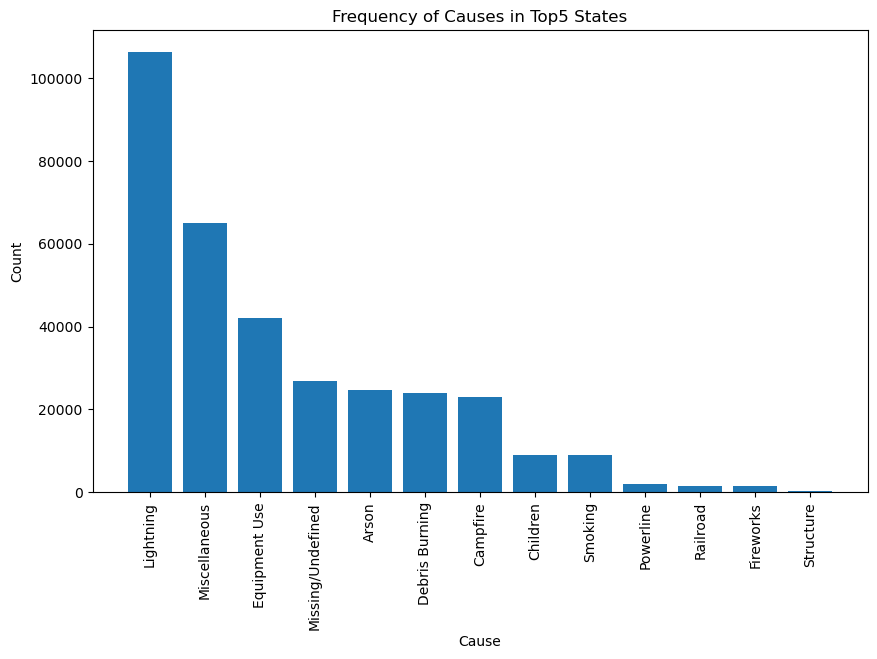

In [16]:
# Assuming 'cause_count' is your DataFrame
plt.figure(figsize=(10, 6))  # Set the size of the plot (optional)

# Plot the bar chart
plt.bar(cause_count['cause'], cause_count['count'])

# Add labels and title
plt.xlabel('Cause')
plt.ylabel('Count')
plt.title('Frequency of Causes in Top5 States')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

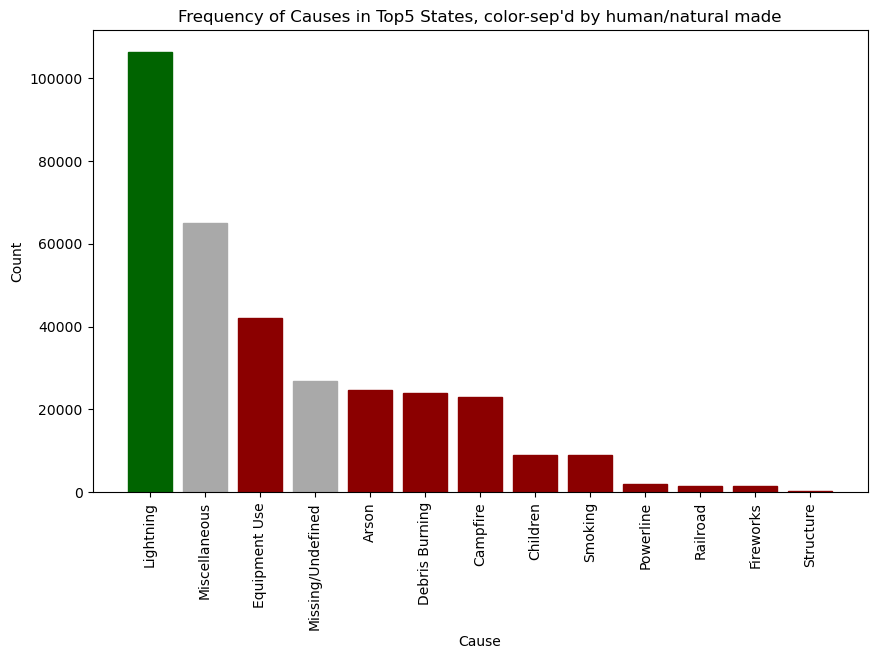

In [17]:
# Define colors for each 'cause'
color_dict = {
    'Lightning': 'darkgreen',
    'Miscellaneous': 'darkgrey',
    'Equipment Use': 'darkred',
    'Missing/Undefined': 'darkgrey',
    'Arson': 'darkred',
    'Debris Burning': 'darkred',
    'Campfire': 'darkred',
    'Children': 'darkred',
    'Smoking': 'darkred',
    'Powerline': 'darkred',
    'Railroad': 'darkred',
    'Fireworks': 'darkred',
    'Structure': 'darkred'
}

plt.figure(figsize=(10, 6))

# Plot the bar chart with custom colors
bars = plt.bar(cause_count['cause'], cause_count['count'])

# Colorize the bars based on the 'cause' values
for i, bar in enumerate(bars):
    bar.set_color(color_dict[cause_count['cause'][i]])

# Add labels and title
plt.xlabel('Cause')
plt.ylabel('Count')
plt.title("Frequency of Causes in Top5 States, color-sep'd by human/natural made")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [18]:
# Calculate the total count
total_count = cause_count['count'].sum()

# Calculate the percentage distribution
cause_count['percentage'] = (cause_count['count'] / total_count) * 100

cause_count['percentage'] = round(cause_count['percentage'], 2)
# Now, 'cause_count' DataFrame will have a new 'percentage' column
# containing the percentage distribution for each 'cause'

In [19]:
#total cause count and percentage
cause_count

,cause,count,percentage
0,Lightning,106307,31.73
1,Miscellaneous,65114,19.44
2,Equipment Use,41965,12.53
3,Missing/Undefined,26862,8.02
4,Arson,24605,7.34
5,Debris Burning,23994,7.16
6,Campfire,22958,6.85
7,Children,9080,2.71
8,Smoking,8960,2.67
9,Powerline,1929,0.58


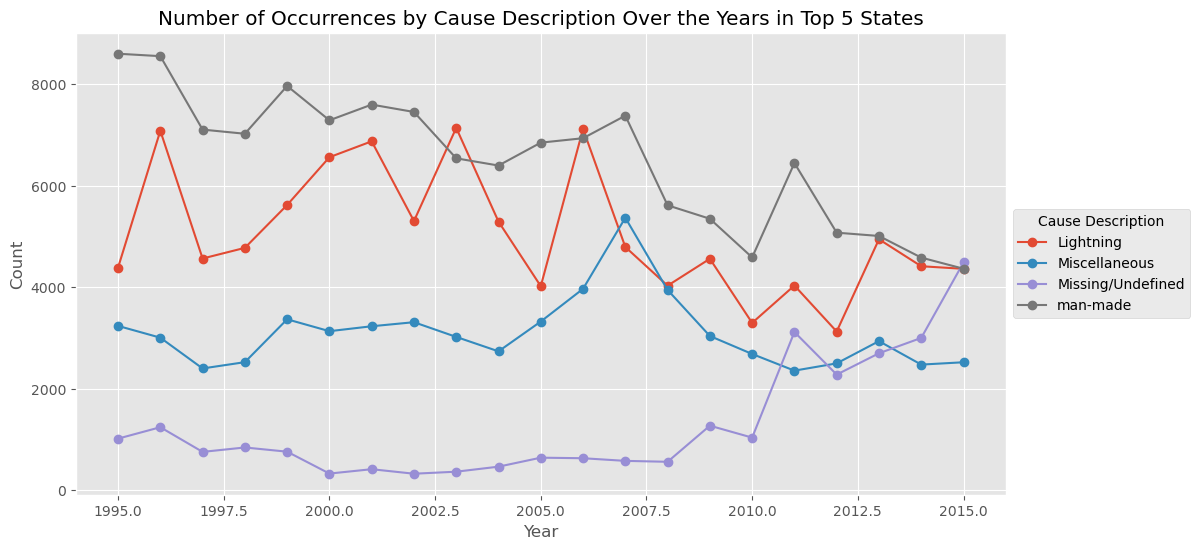

In [20]:
data_grouped = filtered_data.groupby(['year', 'cause_compact']).size().reset_index(name='count')

# Set the style of the plot (optional)
plt.style.use('ggplot')

# Pivot the data to create a pivot table for the line chart
pivot_table = data_grouped.pivot(index='year', columns='cause_compact', values='count')

# Create the line chart
pivot_table.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Number of Occurrences by Cause Description Over the Years in Top 5 States')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Cause Description', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid(True)

# Show the plot
plt.show()

### California causes

In [21]:
#save value count of cause description of California data in a variable
california_cause_numbers = california_data['cause_descr'].value_counts()

# Convert the result to a DataFrame
california_cause_count = pd.DataFrame({'cause': california_cause_numbers.index, 'count': california_cause_numbers.values})

# Calculate the total count
total_count = california_cause_count['count'].sum()

# Calculate the percentage distribution
california_cause_count['percentage'] = (california_cause_count['count'] / total_count) * 100

california_cause_count['percentage'] = round(california_cause_count['percentage'], 2)
# Now, 'cause_count' DataFrame will have a new 'percentage' column
# containing the percentage distribution for each 'cause'

In [22]:
california_cause_count

,cause,count,percentage
0,Miscellaneous,44975,27.80
1,Equipment Use,32816,20.28
2,Lightning,22096,13.66
3,Arson,16634,10.28
4,Missing/Undefined,12602,7.79
5,Debris Burning,12257,7.58
6,Campfire,8184,5.06
7,Children,5532,3.42
8,Smoking,4697,2.90
9,Powerline,1122,0.69


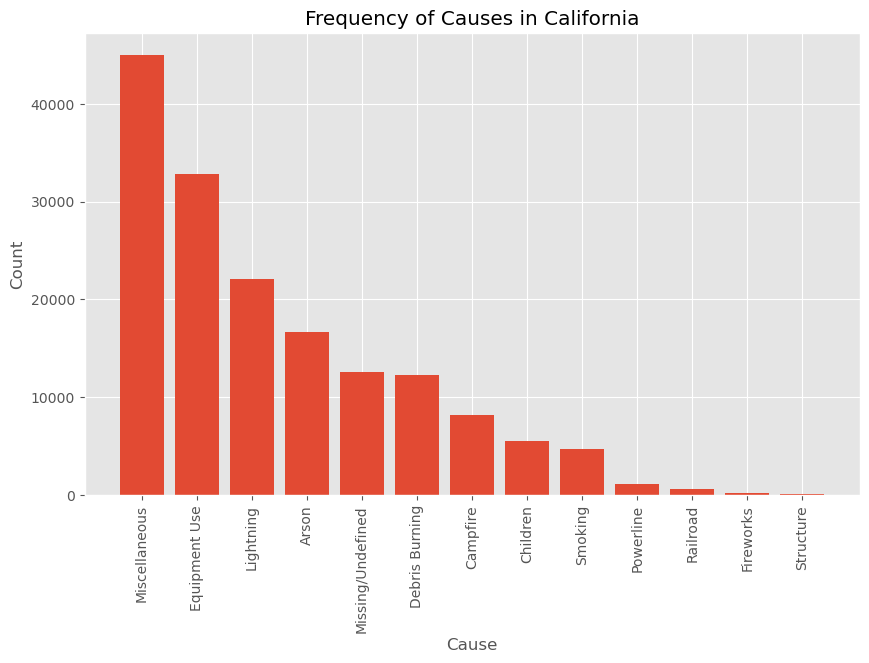

In [23]:
# Define colors for each 'cause'
color_dict = {
    'Lightning': 'darkgreen',
    'Miscellaneous': 'darkgrey',
    'Equipment Use': 'darkred',
    'Missing/Undefined': 'darkgrey',
    'Arson': 'darkred',
    'Debris Burning': 'darkred',
    'Campfire': 'darkred',
    'Children': 'darkred',
    'Smoking': 'darkred',
    'Powerline': 'darkred',
    'Railroad': 'darkred',
    'Fireworks': 'darkred',
    'Structure': 'darkred'
}

plt.figure(figsize=(10, 6))

# Plot the bar chart with custom colors
bars = plt.bar(california_cause_count['cause'], california_cause_count['count'])

# Colorize the bars based on the 'cause' values
#for i, bar in enumerate(bars):
#    bar.set_color(color_dict[cause_count['cause'][i]])

# Add labels and title
plt.xlabel('Cause')
plt.ylabel('Count')
plt.title("Frequency of Causes in California")#, color-sep'd by human/natural made")

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [24]:
california_data.head(10)

,unique_id,state_name,combined_discovery_date,fire_size,cause_descr,month,quarter,season,year,cause_compact
115,1386025,California,2010-06-20,0.3,Campfire,6,2,summer,2010,man-made
214,1386026,California,2010-06-20,0.3,Miscellaneous,6,2,summer,2010,Miscellaneous
440,1386029,California,2010-06-21,0.1,Miscellaneous,6,2,summer,2010,Miscellaneous
464,1386030,California,2010-06-21,1.0,Smoking,6,2,summer,2010,man-made
488,1386031,California,2010-06-21,1.0,Miscellaneous,6,2,summer,2010,Miscellaneous
512,1386034,California,2010-06-22,1.0,Debris Burning,6,2,summer,2010,man-made
611,1386035,California,2010-06-22,2.0,Equipment Use,6,2,summer,2010,man-made
635,1386037,California,2010-06-23,1.0,Arson,6,2,summer,2010,man-made
659,1386039,California,2010-06-29,0.3,Miscellaneous,6,2,summer,2010,Miscellaneous
683,1386041,California,2010-06-30,0.2,Smoking,6,2,summer,2010,man-made


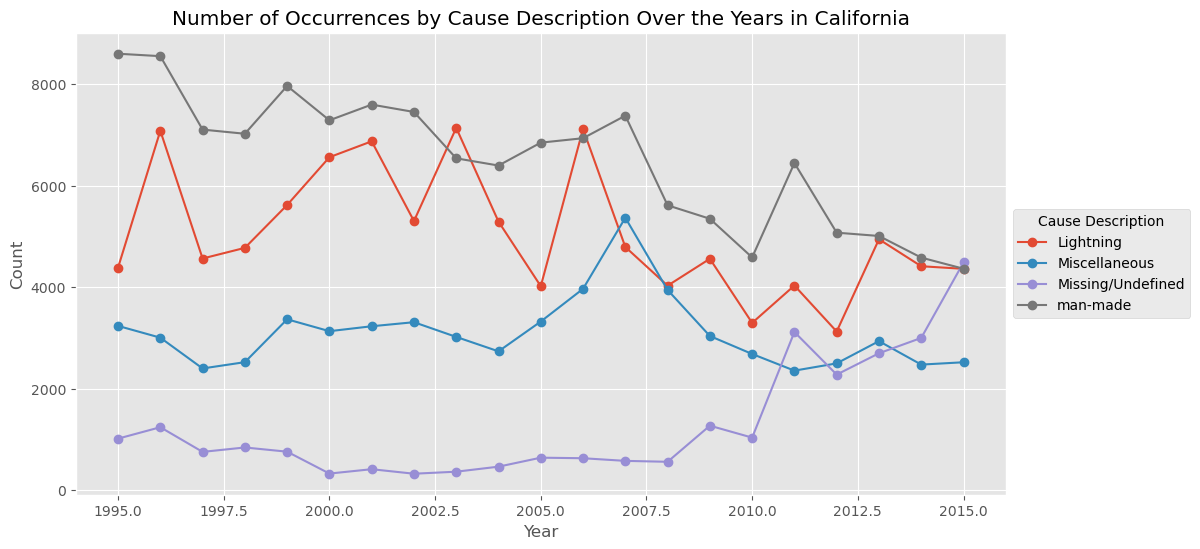

In [25]:
#group the California data by year and cause compact to count the occurrences 
california_grouped = california_data.groupby(['year', 'cause_compact']).size().reset_index(name='count')

plt.style.use('ggplot')

# Pivot the data to create a pivot table for the line chart
pivot_table = data_grouped.pivot(index='year', columns='cause_compact', values='count')

# Create the line chart
pivot_table.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Number of Occurrences by Cause Description Over the Years in California')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Cause Description', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid(True)

# Show the plot
plt.show()

In [26]:
california_grouped.head(10)

,year,cause_compact,count
0,1995,Lightning,549
1,1995,Miscellaneous,1966
2,1995,Missing/Undefined,3
3,1995,man-made,4862
4,1996,Lightning,1414
5,1996,Miscellaneous,2186
6,1996,Missing/Undefined,7
7,1996,man-made,5566
8,1997,Lightning,1100
9,1997,Miscellaneous,1985


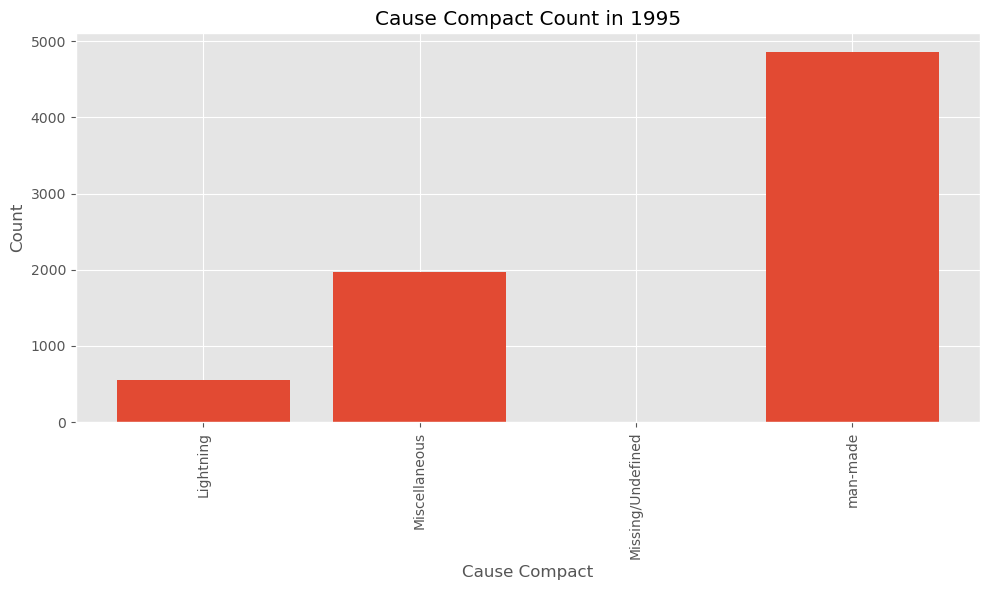

In [27]:
# narrow down to 1995
california_1995 = california_grouped[california_grouped['year'] == 1995]

# Create a bar plot to visualize the 'count' of each 'cause_compact'
plt.figure(figsize=(10, 6))
plt.bar(california_1995['cause_compact'], california_1995['count'])
plt.xlabel('Cause Compact')
plt.ylabel('Count')
plt.title('Cause Compact Count in 1995')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
# Calculate the total count for the year 2015
total_count_1995 = california_1995['count'].sum()

# Add a new column 'percentage' to 'california_2015'
california_1995['percentage'] = (california_1995['count'] / total_count_1995) * 100

# Display the updated DataFrame
print(california_1995)

   year      cause_compact  count  percentage
0  1995          Lightning    549    7.439024
1  1995      Miscellaneous   1966   26.639566
2  1995  Missing/Undefined      3    0.040650
3  1995           man-made   4862   65.880759


/var/folders/71/74jym8nn07z_r531l25_2hd00000gn/T/ipykernel_1993/2752276412.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  california_1995['percentage'] = (california_1995['count'] / total_count_1995) * 100


In [29]:
# narrow down California counts to 2015
california_2015 = california_grouped[california_grouped['year'] == 2015]

# Calculate the total count for the year 2015
total_count_2015 = california_2015['count'].sum()

# Add a new column 'percentage' to 'california_2015'
california_2015['percentage'] = (california_2015['count'] / total_count_2015) * 100

# Display the updated DataFrame
print(california_2015)



    year      cause_compact  count  percentage
80  2015          Lightning   1459   19.809912
81  2015      Miscellaneous   1753   23.801765
82  2015  Missing/Undefined   1687   22.905635
83  2015           man-made   2466   33.482688


/var/folders/71/74jym8nn07z_r531l25_2hd00000gn/T/ipykernel_1993/1151824218.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  california_2015['percentage'] = (california_2015['count'] / total_count_2015) * 100


In [30]:
print(california_2015)

    year      cause_compact  count  percentage
80  2015          Lightning   1459   19.809912
81  2015      Miscellaneous   1753   23.801765
82  2015  Missing/Undefined   1687   22.905635
83  2015           man-made   2466   33.482688


In [31]:
print(california_grouped)

    year      cause_compact  count
0   1995          Lightning    549
1   1995      Miscellaneous   1966
2   1995  Missing/Undefined      3
3   1995           man-made   4862
4   1996          Lightning   1414
..   ...                ...    ...
79  2014           man-made   2492
80  2015          Lightning   1459
81  2015      Miscellaneous   1753
82  2015  Missing/Undefined   1687
83  2015           man-made   2466

[84 rows x 3 columns]


In [32]:
california_data['cause_compact'].value_counts()

cause_compact
man-made             82107
Miscellaneous        44975
Lightning            22096
Missing/Undefined    12602
Name: count, dtype: int64

In [33]:
california_data['year'].value_counts()

year
2007    10151
1996     9173
1999     8906
2013     8723
2011     8562
2006     8271
2001     8182
1997     7930
2003     7913
2008     7742
2004     7416
1995     7380
2015     7365
2012     7207
2002     7132
2000     6976
2009     6940
1998     6864
2005     6677
2014     6494
2010     5776
Name: count, dtype: int64

In [34]:
print(california_1995)

   year      cause_compact  count  percentage
0  1995          Lightning    549    7.439024
1  1995      Miscellaneous   1966   26.639566
2  1995  Missing/Undefined      3    0.040650
3  1995           man-made   4862   65.880759


In [35]:
total_count_1995

7380